In [1]:
!pip install plot_keras_history

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 15 21:39:26 2020

@author: isswan
"""

import pandas as pd
import numpy as np

from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D,Reshape, Dense, Dropout, Flatten, MaxPooling1D, Input, Concatenate
from keras.models import load_model

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib

import matplotlib.pyplot as plt
from plot_keras_history import plot_history



<Figure size 432x288 with 0 Axes>

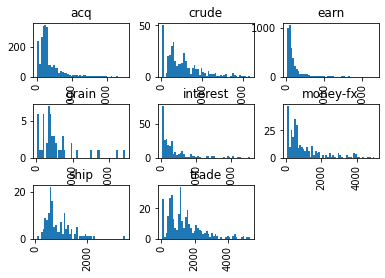

<Figure size 432x288 with 0 Axes>

In [5]:
#Data Preparation
import pandas as pd
news=pd.read_table('r8-full-data.txt',header=None,names = ["Class", "Text"])
news.head()
a = news.groupby("Class")
a.head()
a.describe()
y=news['Class']
X=news['Text']

##check the length to determine the document length for DNN

length=news['Text'].apply(len)
news=news.assign(Length=length)

#Plot the distribution of the document length for each category
import matplotlib.pyplot as plt
news.hist(column='Length',by='Class',bins=50)

plt.figure()

In [6]:
#Data Preprocessing 

# Split train & test
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)
X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in X_train) # longest text in train set
print('vocabubary size:',vocab_size)
print('max length text:',maxlen)

#Padding the sentences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#embedding dimension should align with the GLOVE
embedding_dim = 100
vocab_size = len(word_index) + 1

GLOVE_6B_100D_PATH ="glove.6B.100d.txt"
encoding="utf-8"
with open(GLOVE_6B_100D_PATH, "rb") as lines:
    embeddings_index = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

# Prepare embedding matrix from pre-trained model
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)   

vocabubary size: 19998
max length text: 964
0.848034803480348


In [7]:
#create class weight dict for unbanlanced dataset
#If 'balanced', class weights will be given by n_samples / (n_classes * np.bincount(y)

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights_d = dict(enumerate(class_weights))

##onehot encoding for y
def categoricalList2Onehot(listOfClasses):
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(listOfClasses)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded

y_train_onehot = categoricalList2Onehot(y_train)
y_train_onehot.shape
y_test_onehot = categoricalList2Onehot(y_test)
y_test_onehot.shape

c:\anaconda\envs\pyakc\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=['acq' 'crude' 'earn' 'grain' 'interest' 'money-fx' 'ship' 'trade'], y=3759    ship
2907    ship
4935    earn
1396    earn
931      acq
        ... 
905      acq
5192    earn
3980    earn
235     earn
5157    earn
Name: Class, Length: 5371, dtype: object as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


(2303, 8)

In [8]:
# Shallow CNN
# Todo: replace the "???" with correct piece of code
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model.add(Conv1D(512, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(8, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 964, 100)          1999800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 962, 512)          154112    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4104      
Total params: 2,158,016
Trainable params: 158,216
Non-trainable params: 1,999,800
_________________________________________________________________


Train on 5371 samples, validate on 2303 samples
Epoch 1/11
5371/5371 [==============================] - 4s 821us/step - loss: 0.9288 - accuracy: 0.7803 - val_loss: 0.3367 - val_accuracy: 0.9036
Epoch 2/11
5371/5371 [==============================] - 2s 392us/step - loss: 0.1802 - accuracy: 0.9434 - val_loss: 0.2113 - val_accuracy: 0.9323
Epoch 3/11
5371/5371 [==============================] - 2s 392us/step - loss: 0.0922 - accuracy: 0.9669 - val_loss: 0.1701 - val_accuracy: 0.9453
Epoch 4/11
5371/5371 [==============================] - 2s 395us/step - loss: 0.0643 - accuracy: 0.9754 - val_loss: 0.1686 - val_accuracy: 0.9440
Epoch 5/11
5371/5371 [==============================] - 2s 396us/step - loss: 0.0434 - accuracy: 0.9840 - val_loss: 0.1352 - val_accuracy: 0.9535
Epoch 6/11
5371/5371 [==============================] - 2s 396us/step - loss: 0.0332 - accuracy: 0.9864 - val_loss: 0.1217 - val_accuracy: 0.9561
Epoch 7/11
5371/5371 [==============================] - 2s 396us/step - loss

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

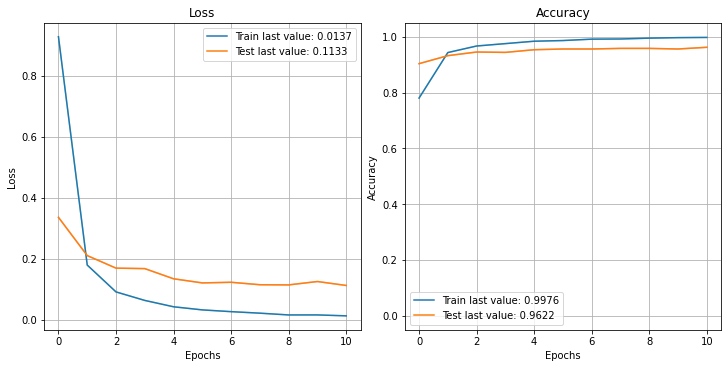

In [9]:
#train the model

hist = model.fit(X_train, y_train_onehot,
                    class_weight = class_weights_d,
                    epochs=11,
                    verbose=True,
                    validation_data=(X_test, y_test_onehot),
                    batch_size=64).history

loss, accuracy = model.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

In [10]:
# Excersice : Modify Shallow CNN with dropout Layer
#To do: add Dropout layer within the model defination and correct the ???

model_dp = Sequential()
model_dp.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model_dp.add(Conv1D(512, 3, activation='relu'))
model_dp.add(GlobalMaxPooling1D())
#model_dp.add(Dense(64, activation=???))
#dropout layer
model_dp.add(Dense(8, activation='sigmoid'))
model_dp.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.add(Dropout(0.5))
model_dp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 964, 100)          1999800   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 962, 512)          154112    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 4104      
Total params: 2,158,016
Trainable params: 158,216
Non-trainable params: 1,999,800
_________________________________________________________________


Train on 5371 samples, validate on 2303 samples
Epoch 1/8
5371/5371 [==============================] - 2s 414us/step - loss: 1.1119 - accuracy: 0.6129 - val_loss: 0.2770 - val_accuracy: 0.9201
Epoch 2/8
5371/5371 [==============================] - 2s 397us/step - loss: 0.2006 - accuracy: 0.9363 - val_loss: 0.1989 - val_accuracy: 0.9331
Epoch 3/8
5371/5371 [==============================] - 2s 398us/step - loss: 0.0960 - accuracy: 0.9657 - val_loss: 0.1726 - val_accuracy: 0.9396
Epoch 4/8
5371/5371 [==============================] - 2s 396us/step - loss: 0.0596 - accuracy: 0.9758 - val_loss: 0.1485 - val_accuracy: 0.9505
Epoch 5/8
5371/5371 [==============================] - 2s 400us/step - loss: 0.0445 - accuracy: 0.9821 - val_loss: 0.1324 - val_accuracy: 0.9544
Epoch 6/8
5371/5371 [==============================] - 2s 399us/step - loss: 0.0328 - accuracy: 0.9872 - val_loss: 0.1359 - val_accuracy: 0.9522
Epoch 7/8
5371/5371 [==============================] - 2s 397us/step - loss: 0.027

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

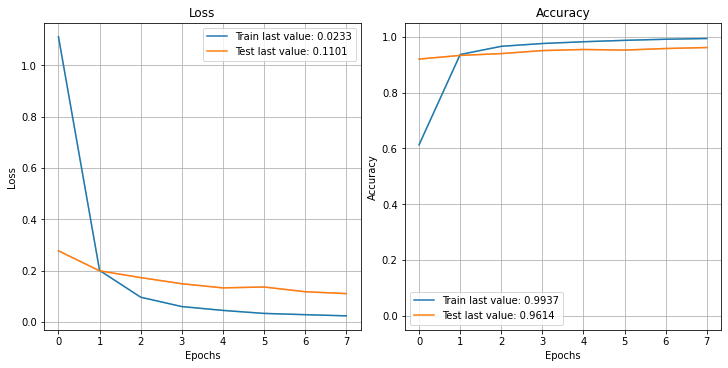

In [11]:
#train the model

hist_dp = model_dp.fit(X_train, y_train_onehot,
                    class_weight = class_weights_d,
                    epochs=8,
                    verbose=True,
                    validation_data=(X_test, y_test_onehot),
                    batch_size=64).history

loss, accuracy = model_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_dp)

In [12]:
##Deep CNN 
# define the model
from keras.layers.merge import concatenate
from keras.models import Model

def define_model(length, vocab_size,embedding_dim):
	# channel 1
	inputs1 = Input(shape=(length,))
	embedding1 = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(inputs1)
	conv1 = Conv1D(filters=128, kernel_size=2, activation='relu')(embedding1)
	drop1 = Dropout(0.5)(conv1)
	pool1 = MaxPooling1D(pool_size=2)(drop1)
	flat1 = Flatten()(pool1)
	# channel 2
	inputs2 = Input(shape=(length,))
	embedding2 = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(inputs2)
	conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding2)
	drop2 = Dropout(0.5)(conv2)
	pool2 = MaxPooling1D(pool_size=2)(drop2)
	flat2 = Flatten()(pool2)
	# channel 3
	inputs3 = Input(shape=(length,))
	embedding3 = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(inputs3)
	conv3 = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding3)
	drop3 = Dropout(0.5)(conv3)
	pool3 = MaxPooling1D(pool_size=2)(drop3)
	flat3 = Flatten()(pool3)
	# merge
	merged = concatenate([flat1, flat2, flat3])
	# interpretation
	dense1 = Dense(64, activation='relu')(merged)
	outputs = Dense(8, activation='softmax')(dense1)
	model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# summarize
	print(model.summary())
	return model

model_deep = define_model(maxlen,vocab_size,embedding_dim)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 964)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 964)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 964)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 964, 100)     1999800     input_1[0][0]                    
____________________________________________________________________________________________

Train on 5371 samples, validate on 2303 samples
Epoch 1/5
5371/5371 [==============================] - 4s 711us/step - loss: 1.8461 - accuracy: 0.6773 - val_loss: 0.7383 - val_accuracy: 0.7799
Epoch 2/5
5371/5371 [==============================] - 3s 601us/step - loss: 0.3040 - accuracy: 0.9131 - val_loss: 0.2998 - val_accuracy: 0.9101
Epoch 3/5
5371/5371 [==============================] - 3s 602us/step - loss: 0.0782 - accuracy: 0.9736 - val_loss: 0.2325 - val_accuracy: 0.9292
Epoch 4/5
5371/5371 [==============================] - 3s 599us/step - loss: 0.0383 - accuracy: 0.9836 - val_loss: 0.2391 - val_accuracy: 0.9314
Epoch 5/5
5371/5371 [==============================] - 1s 239us/step
Training Accuracy: 0.9966
Testing Accuracy:  0.9444


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

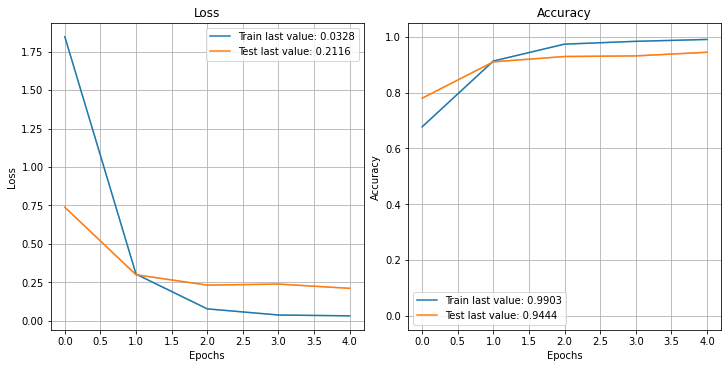

In [13]:
#train the model

hist_deep = model_deep.fit([X_train,X_train,X_train], y_train_onehot,
                    class_weight = class_weights_d,
                    epochs=5,
                    verbose=True,
                    validation_data=([X_test,X_test,X_test], y_test_onehot),
                    batch_size=64).history

loss, accuracy = model_deep.evaluate([X_train,X_train,X_train], y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_deep.evaluate([X_test,X_test,X_test], y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_deep)

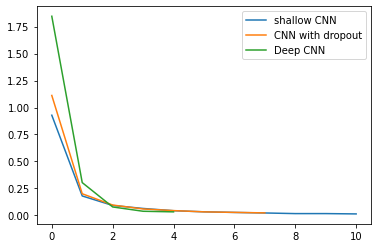

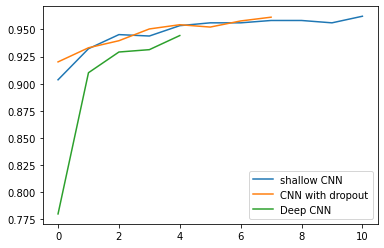

In [14]:
#Compare all the models

plt.plot(hist['loss'], label='shallow CNN')
plt.plot(hist_dp['loss'], label='CNN with dropout')
plt.plot(hist_deep['loss'], label='Deep CNN')
plt.legend(loc='upper right')
plt.show()

plt.plot(hist['val_accuracy'], label='shallow CNN')
plt.plot(hist_dp['val_accuracy'], label='CNN with dropout')
plt.plot(hist_deep['val_accuracy'], label='Deep CNN')
plt.legend(loc='lower right')
plt.show()
